# Manual linear regression

Play around with simple linear regression loss minimization with gradient descent without typical machine learning libraries. The dataset is on life expectancy and related health, economic, and social factors for 193 countries from 2000 to 2015, sourced from WHO and UN.
  

Structure:

    1. Load data and libraries
    2. EDA
    3. Data selection
    4. Test models
        4.1 Vanilla gradient descent
        4.2 Gradient descent with momentum
        4.3 Gradient descent with variable standardization

## 1) Load data and import libraries

In [264]:
import math
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from IPython import display

df = pd.read_csv('Life Expectancy Data.csv')

## 2) Explanatory data analysis (EDA)

2.1) Overview and descriptive statistics<br>
2.2) Feature assessment and visualisation<br>
2.3) Data quality evaluation<br>

### 2.1) Overview and descriptive statistics

In [265]:
print('\n______________________________________________\n')
print(f'Shape:\n\n{df.shape}')
print('\n______________________________________________\n')
print(f'Describe:\n\n{df.describe()}')
print('\n______________________________________________\n')
print(f'Missing data (nan values):\n\n{df.isnull().sum()}')
print('\n______________________________________________\n')
print(f'Info:\n\n{df.info()}')
print('\n______________________________________________\n')


______________________________________________

Shape:

(2938, 22)

______________________________________________

Describe:

              Year  Life expectancy   Adult Mortality  infant deaths  \
count  2938.000000       2928.000000      2928.000000    2938.000000   
mean   2007.518720         69.224932       164.796448      30.303948   
std       4.613841          9.523867       124.292079     117.926501   
min    2000.000000         36.300000         1.000000       0.000000   
25%    2004.000000         63.100000        74.000000       0.000000   
50%    2008.000000         72.100000       144.000000       3.000000   
75%    2012.000000         75.700000       228.000000      22.000000   
max    2015.000000         89.000000       723.000000    1800.000000   

           Alcohol  percentage expenditure  Hepatitis B       Measles   \
count  2744.000000             2938.000000  2385.000000    2938.000000   
mean      4.602861              738.251295    80.940461    2419.592240   
s

Plot the features againts life expectancy with correlation coefficients. 

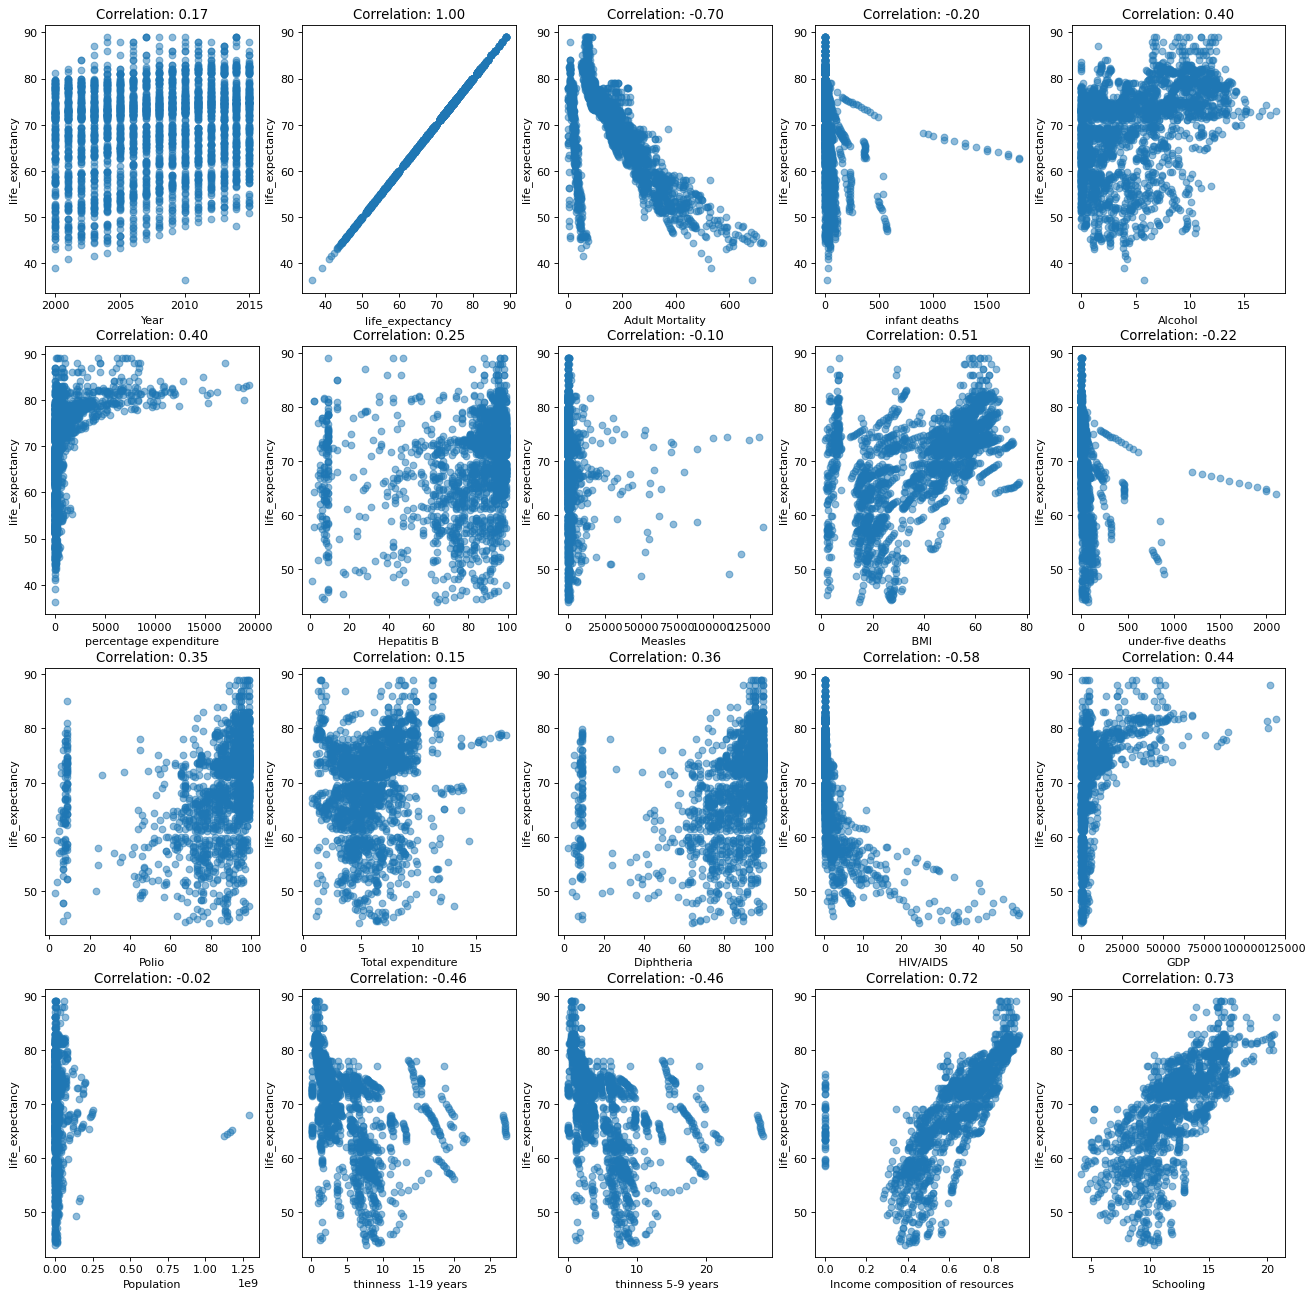

In [266]:
# Drop non-numeric columns
df = df.drop(columns=df.select_dtypes(exclude=['int', 'float']).columns)

df.rename(columns={'Life expectancy ': 'life_expectancy'}, inplace=True)

# Plot all features against life expectancy to get a good candidate for regression excercise
cols = math.ceil(np.sqrt(len(df.columns)))
rows = math.ceil(len(df.columns) / cols)

fig, ax = plt.subplots(rows, cols, figsize=(20, 20), dpi=80)
ax = ax.flatten()

for i, col in enumerate(df.columns):

    # Imputation for missing values
    df = df.dropna(subset=['life_expectancy', col])

    x = df[col]
    y = df['life_expectancy']

    corr = x.corr(y)

    ax[i].scatter(x, y, alpha=0.5)
    ax[i].set_title(f'Correlation: {corr:.2f}')
    ax[i].set_xlabel(x.name)
    ax[i].set_ylabel(y.name)

plt.show()

## 3) Data selection

Select a feature from the dataset that seem to have sufficient linear dependency.

Plot the selected data and analytically fitted linear fit as a reference for later modeling.

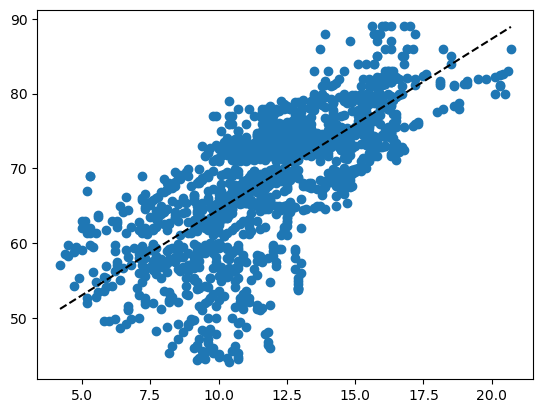

In [267]:
# Select features
df_cut = df[['life_expectancy', 'Schooling']]

# Drop zero values to improve correlation
df_cut = df_cut[df_cut['Schooling'] > 0]
x, y = df_cut['Schooling'], df_cut['life_expectancy']

# Plot analytically solved linear regression fit
plt.figure()
plt.scatter(x, y)
coeffs = np.polyfit(x, y, deg=1)
x_fit = np.linspace(x.min(), x.max(), len(x))
fit = np.polyval(coeffs, x_fit)
plt.plot(x_fit, fit, c='k', ls='--')
plt.show()

Function for coefficient of determination: the proportion of variance in the dependent variable that can be explained by the independent variable. Goodness of the fir - the closer to 1 the stonger the dependency.


In [268]:
def r_squared(y_true, y_pred):

    # Residual sum of squares
    ss_res = np.sum((y_true - y_pred)**2)
    ss_tot = np.sum((y_true - np.mean(y_true))**2)

    return (1 - (ss_res / ss_tot))

## 4) Test models

### 4.1) Vanilla gradient descent, MSE loss

Fit the regression line iteratively by minimizing the MSE loss function and by moving towards the negative derivative of each fit coefficient.

Result:
The Vanilla gradient desent seems to begin finding the minimum but converges slow, or begins to diverge with higher learning rates.


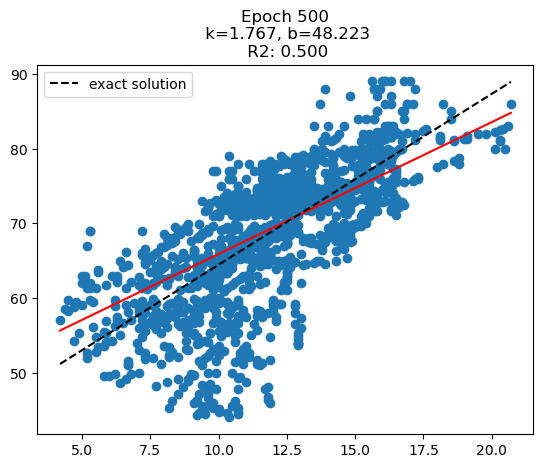

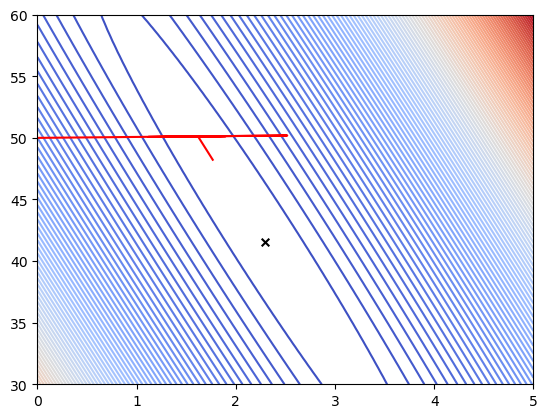

In [269]:
%matplotlib inline

# Initialize model params
k = 0
b = 50
lr = 0.005
epochs = 500


# Set up figure
fig, ax = plt.subplots(1, 1)
ax.scatter(x, y)

# Initial predictions
y_pred = k * x + b
line, = ax.plot([x.min(), x.max()], [y_pred.min(), y_pred.max()], c='r')

# Plot analytically solved line fit
ax.plot(x_fit, fit, c='k', ls='--', label='exact solution')
ax.legend()

n = float(len(x))

# Track k and b paths for contour plot
path_k = [k]
path_b = [b]

# Gradient descent
for i in range(epochs):

    # Partial derivative of the MSE loss function with respect to k
    d_k = (-2/n) * sum(x * (y - y_pred))

    # Partial derivative of the MSE loss function with respect to b
    d_b = (-2/n) * sum(y - y_pred)

    # Update k and b based on derivatives
    k = k - (lr * d_k)
    b = b - (lr * d_b)

    path_k.append(k)
    path_b.append(b)

    # Predicted y with linear fit
    y_pred = k * x + b

    r2 = r_squared(y, y_pred)

    # Update line plot
    line.set_ydata([y_pred.min(), y_pred.max()])
    ax.set_title(f'Epoch {i+1}\n k={k:.3f}, b={b:.3f}\n R2: {r2:.3f}')

    display.display(plt.gcf())
    display.clear_output(wait=True)


# Contour plot of loss minimization
k_vals = np.linspace(0, 5, 100)
b_vals = np.linspace(30, 60, 100)
K, B = np.meshgrid(k_vals, b_vals)

# Loss for each point
loss_grid = np.zeros_like(K)
for i in range(K.shape[0]):
    for j in range(K.shape[1]):
        y_pred_grid = K[i, j] * x + B[i, j]
        loss_grid[i, j] = np.mean((y - y_pred_grid) ** 2)

plt.figure()
c_plot = plt.contour(K, B, loss_grid, levels=100, cmap='coolwarm')
plt.scatter(coeffs[0], coeffs[1], c='k', marker='x', s=30, label='exact solution')
plt.plot(path_k, path_b, c='r')
plt.show()

### 4.2) Momentum gradient descent, MSE loss

Same system but now velocity is introduced to the model. Parameter updates are influenced by the current gradient and a fraction of the previous. 

Result:
The initial movements are more extreme as expected but the convergence is not really accelerated. Might be that the slow convergence is due to unbalanced x and y-axis values.


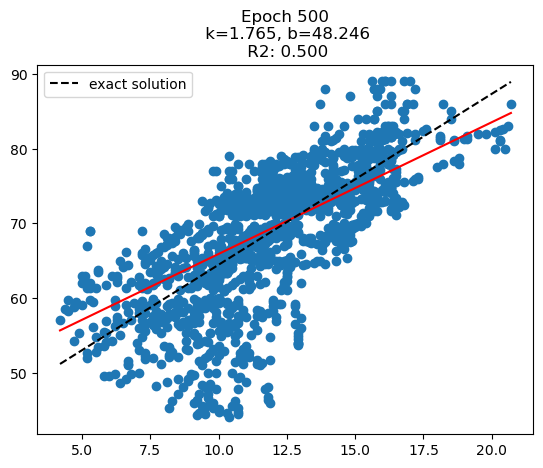

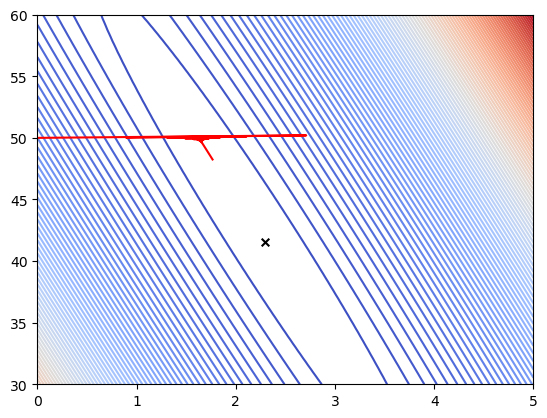

In [270]:
%matplotlib inline

# Initialize model params
k = 0
b = 50
lr = 0.005
epochs = 500

# Velocities
v_k = 0
v_b = 0

# Momentum coefficient
gamma = 0.9

# Set up figure
fig, ax = plt.subplots(1, 1)
ax.scatter(x, y)

# Initial predictions
y_pred = k * x + b
line, = ax.plot([x.min(), x.max()], [y_pred.min(), y_pred.max()], c='r')

# Plot analytically solved line fit
ax.plot(x_fit, fit, c='k', ls='--', label='exact solution')
ax.legend()

n = float(len(x))

# Track k and b paths for contour plot
path_k = [k]
path_b = [b]

# Gradient descent
for i in range(epochs):

    # Partial derivative of the MSE loss function with respect to k
    d_k = (-2/n) * sum(x * (y - y_pred))

    # Partial derivative of the MSE loss function with respect to b
    d_b = (-2/n) * sum(y - y_pred)

    # Update velocities
    v_k = gamma * v_k + (1 - gamma) * d_k
    v_b = gamma * v_b + (1 - gamma) * d_b

    # Update k and b based on derivatives
    k = k - (lr * v_k)
    b = b - (lr * v_b)

    path_k.append(k)
    path_b.append(b)

    # Predicted y with linear fit
    y_pred = k * x + b

    r2 = r_squared(y, y_pred)

    # Update line plot
    line.set_ydata([y_pred.min(), y_pred.max()])
    ax.set_title(f'Epoch {i+1}\n k={k:.3f}, b={b:.3f}\n R2: {r2:.3f}')

    display.display(plt.gcf())
    display.clear_output(wait=True)


# Contour plot of loss minimization
k_vals = np.linspace(0, 5, 100)
b_vals = np.linspace(30, 60, 100)
K, B = np.meshgrid(k_vals, b_vals)

# Loss for each point
loss_grid = np.zeros_like(K)
for i in range(K.shape[0]):
    for j in range(K.shape[1]):
        y_pred_grid = K[i, j] * x + B[i, j]
        loss_grid[i, j] = np.mean((y - y_pred_grid) ** 2)

plt.figure()
c_plot = plt.contour(K, B, loss_grid, levels=100, cmap='coolwarm')
plt.scatter(coeffs[0], coeffs[1], c='k', marker='x', s=30, label='exact solution')
plt.plot(path_k, path_b, c='r')
plt.show()

### 4.3) Vanilla gradient descent with variable standardization, MSE loss

Let's introduce standardization for x and y, and see how convergence changes. 

Result:
Convergence becomes much faster and the system does not diverge with higher learning rates. The standardized coefficients are destandardized back to the original scale.


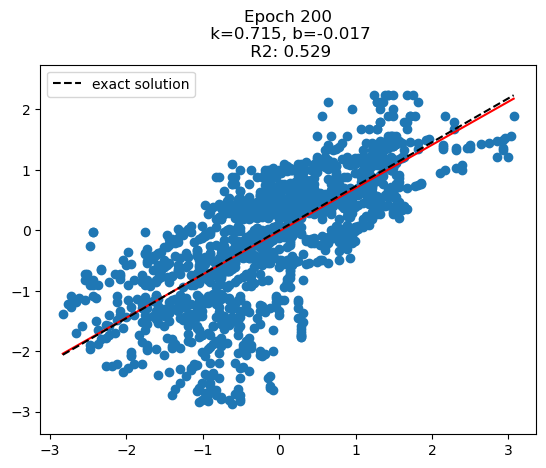

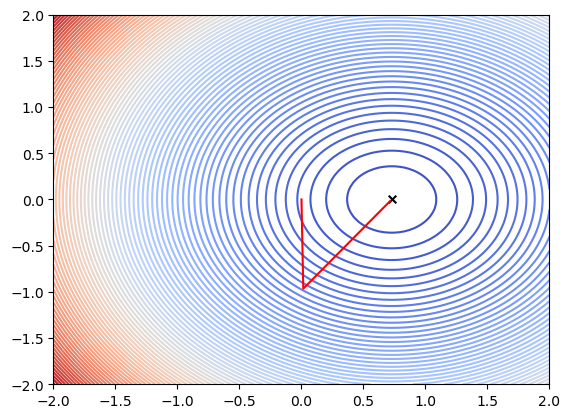

In [272]:
# Standardized x and y
x_std = (x - x.mean()) / x.std()
y_std = (y - y.mean()) / y.std()

# New analytically solved fit coeffs for scaled variables
coeffs_std = np.polyfit(x_std, y_std, deg=1)
x_fit_std = np.linspace(x_std.min(), x_std.max(), len(x))
fit_std = np.polyval(coeffs_std, x_fit_std)

%matplotlib inline

# Initialize model params
k_std = 0
b_std = 0
lr = 0.01
epochs = 200


# Set up figure
fig, ax = plt.subplots(1, 1)
ax.scatter(x_std, y_std)
ax.set_ylim([y_std.min() - 0.5 * y_std.std(), y_std.max() + 0.5 * y_std.std()])

# Initial predictions
y_pred = k_std * x_std + b
line, = ax.plot([x_std.min(), x_std.max()], [y_pred.min(), y_pred.max()], c='r')

# Plot analytically solved line fit
ax.plot(x_fit_std, fit_std, c='k', ls='--', label='exact solution')
ax.legend()

n = float(len(x_std))

# Track k and b paths for contour plot
path_k = [k_std]
path_b = [b_std]

# Gradient descent
for i in range(epochs):

    # Partial derivative of the MSE loss function with respect to k
    d_k = (-2/n) * sum(x_std * (y_std - y_pred))

    # Partial derivative of the MSE loss function with respect to b
    d_b = (-2/n) * sum(y_std - y_pred)

    # Update k and b based on derivatives
    k_std = k_std - (lr * d_k)
    b_std = b_std - (lr * d_b)

    path_k.append(k_std)
    path_b.append(b_std)

    # Predicted y with linear fit
    y_pred = k_std * x_std + b_std

    r2 = r_squared(y_std, y_pred)

    # Update line plot
    line.set_ydata([y_pred.min(), y_pred.max()])
    ax.set_title(f'Epoch {i+1}\n k={k_std:.3f}, b={b_std:.3f}\n R2: {r2:.3f}')

    display.display(plt.gcf())
    display.clear_output(wait=True)


# Contour plot of loss minimization
k_vals = np.linspace(-2, 2, 100)
b_vals = np.linspace(-2, 2, 100)
K, B = np.meshgrid(k_vals, b_vals)

# Loss for each point
loss_grid = np.zeros_like(K)
for i in range(K.shape[0]):
    for j in range(K.shape[1]):
        y_pred_grid = K[i, j] * x_std + B[i, j]
        loss_grid[i, j] = np.mean((y_std - y_pred_grid) ** 2)

plt.figure()
c_plot = plt.contour(K, B, loss_grid, levels=100, cmap='coolwarm')
plt.scatter(coeffs_std[0], coeffs_std[1], c='k', marker='x', s=30, label='exact solution')
plt.plot(path_k, path_b, c='r')
plt.show()

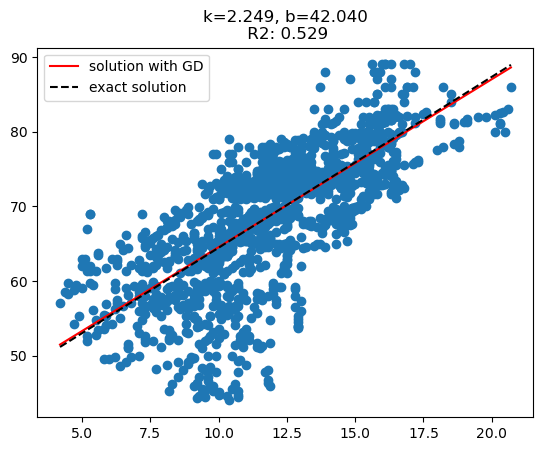

In [273]:
def destandardize(k_s, b_s, mean_x, mean_y, std_x, std_y):
    '''
    Convert standardized values back to original scale.

    Parameters:
    - k_s, b_s: standardized coefficients
    - mean_x, mean_y: original means
    - std_x, std_y: original standard deviations

    Returns:
    - Destandardized coefficients
    '''

    k = k_s * (std_y / std_x)
    b = mean_y - (k * mean_x)

    return k, b


k, b = destandardize(k_std, b_std, x.mean(), y.mean(), x.std(), y.std())

# Set up figure
fig, ax = plt.subplots(1, 1)
ax.scatter(x, y)

# Prediction with destandardized coeffs
y_pred = k * x + b
line, = ax.plot([x.min(), x.max()], [y_pred.min(), y_pred.max()], c='r', label='solution with GD')

r2 = r_squared(y, y_pred)

# Plot analytically solved line fit
ax.plot(x_fit, fit, c='k', ls='--', label='exact solution')

line.set_ydata([y_pred.min(), y_pred.max()])
ax.set_title(f'k={k:.3f}, b={b:.3f}\n R2: {r2:.3f}')

ax.legend()
plt.show()